In [3]:
using Revise
using LazySets
using DifferentialEquations
using LazySets
using ProgressMeter
using ProgressBars
using JLD2
using Flux
using LinearAlgebra
using Zygote
using ReverseDiff
using Plots
using Statistics
using Optimisers, ParameterSchedulers
using RobotDynamics
using RobotZoo
using Random
import RobotDynamics as RD

In [2]:
using CUDA

# Check if GPU is available
if CUDA.functional()
    device!(2)
    CUDA.allowscalar(false)  # Disallow scalar operations on the GPU (optional)
else
    println("GPU is not available. Using CPU.")
end

In [4]:
X = Hyperrectangle(low = [0, 0, 0], high = [4,4, π])
U = Hyperrectangle(low = [-1, -1], high = [1,1])
X_unsafe = Hyperrectangle(low = [1.5, 0,0], high = [2.5,2, π])

Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([2.0, 1.0, 1.5707963267948966], [0.5, 1.0, 1.5707963267948966])

In [5]:
raw_training_data = load_object("car_seq_training_data.jld2")
raw_test_data = load_object("car_seq_test_data.jld2")

3×10001 Matrix{AbstractVector{Float64}}:
 [2.1394, 1.91681, 0.801756]  …  [1.66455, 1.99508, 1.00014]
 [0.290693, -0.214964]           [0.615991, 0.570133]
 [0.0]                           [0.0]

In [ ]:
include("affine_dynamics.jl")
using Flux
using ProgressBars
using JLD2

batchsize = 128
@show sum(raw_training_data[3,:]), size(raw_training_data[3,:])
state_dim = size(reduce(hcat,raw_training_data[1,:]))[1]

training_data = raw_training_data
test_data = raw_test_data

model = Chain(
    Dense(3 => 16, relu),   # activation function inside layer
    Dense(16 => 64, relu),   # activation function inside layer
    Dense(64 => 16, relu),   # activation function inside layer
    Dense(16 => 1)
)

# model = Chain(
#     Dense(3 => 8, relu),   # activation function inside layer
#     Dense(8 => 8, relu),   # activation function inside layer
#     Dense(8 => 8, relu),   # activation function inside layer
#     Dense(8 => 1)
# )

# model = Chain(
#     Dense(3 => 64, relu),   # activation function inside layer
#     Dense(64 => 128, relu),   # activation function inside layer
#     Dense(128 => 64, relu),   # activation function inside layer
#     Dense(64 => 1)
# )


train_loader = Flux.DataLoader(training_data, batchsize=batchsize, shuffle=true)
test_loader = Flux.DataLoader(test_data, batchsize=batchsize, shuffle=true)

λ = 1
μ = 0.1 # the weight of regularization, 0.1 or 1
α = 0.0
use_pgd=true
# lr_alpha = 0.001
lr_lambda = 0.0001
mu = 0.9
# V_alpha=0
V_lambda=0

lr_decay_rate = 0.2
lr_decay_epoch =4
total_epoch = 20

ini_lr = 0.01
optim = Flux.setup(Flux.Optimise.NADAM(ini_lr, (0.9, 0.999), 0.1), model)  # will store optimiser momentum, etc.
sched = ParameterSchedulers.Stateful(Step(ini_lr, lr_decay_rate, lr_decay_epoch)) # setup schedule of your choice

eps = 1e-3
dyn_model = RobotZoo.DubinsCar()
n,m = RD.dims(dyn_model)

training_losses = []
test_losses = []
least_loss = 1000
test_loss = 0
loss = 0
for epoch in ProgressBar(1:total_epoch)
    training_loss_epcoh = []
    test_loss_epcoh = []
    ∇l_lambda = 0
    ∇l_alpha = 0
    for item in train_loader
        ∇l_alpha = 0
        ∇l_lambda = 0
        x_batch = reduce(hcat,item[1,:])
        u_batch = reduce(hcat,item[2,:])
        y_init_batch = reduce(hcat,item[3,:])
        A = []
        B = []
        Δ = []
        for i in 1:size(x_batch, 2)
            z = RD.KnotPoint(x_batch[:, i],u_batch[:, i],0.0,1e-3 ) 
            ∇f = zeros(n, n + m)
            RD.jacobian!(RD.StaticReturn(), RD.ForwardAD(), dyn_model, ∇f, zeros(n), z)
            A_ = ∇f[:, 1:n]
            B_ = ∇f[:, n+1:end]
            Δ_ = RobotDynamics.dynamics(dyn_model, x_batch[:, i] .- eps, u_batch[:, i].-eps) - A_ * (x_batch[:, i].-eps) - B_ * (u_batch[:, i] .- eps)
            push!(A, A_)
            push!(B, B_)
            push!(Δ, Δ_)
        end
        A = cat(A..., dims=3)
        B = cat(B..., dims=3)
        Δ = cat(Δ..., dims=2)
        use_pgd && (u_batch = pgd_find_u_notce(model, A, x_batch, B, u_batch, U; α = α,Δ=Δ))
        training_loss, grads = Flux.withgradient(model) do m 
            loss_naive_safeset(m, x_batch, y_init_batch) + λ .* loss_naive_fi(m, A, x_batch, B, u_batch,y_init_batch;use_pgd=false, α=α,Δ=Δ) + μ .* loss_regularization(m, x_batch, y_init_batch)
        end
        # Update the parameters so as to reduce the objective,
        # according the chosen optimisation rule:
        Flux.update!(optim, model, grads[1])

        loss = loss_naive_safeset(model, x_batch, y_init_batch) + λ .* loss_naive_fi(model, A, x_batch, B, u_batch,y_init_batch;use_pgd=use_pgd, α=α,Δ=Δ) + μ .* loss_regularization(model, x_batch, y_init_batch)
        push!(training_loss_epcoh, loss)  # logging, outside gradient context

    end
    for item in test_loader
        x_batch = reduce(hcat,item[1,:])
        u_batch = reduce(hcat,item[2,:])
        y_init_batch = reduce(hcat,item[3,:])
        A = []
        B = []
        Δ = []
        for i in 1:size(x_batch, 2)
            z = RD.KnotPoint(x_batch[:, i],u_batch[:, i],0.0,1e-3 ) 
            ∇f = zeros(n, n + m)
            RD.jacobian!(RD.StaticReturn(), RD.ForwardAD(), dyn_model, ∇f, zeros(n), z)
            A_ = ∇f[:, 1:n]
            B_ = ∇f[:, n+1:end]
            Δ_ = RobotDynamics.dynamics(dyn_model, x_batch[:, i] .- eps, u_batch[:, i].-eps) - A_ * (x_batch[:, i].-eps) - B_ * (u_batch[:, i] .- eps)
            push!(A, A_)
            push!(B, B_)
            push!(Δ, Δ_)
        end
        A = cat(A..., dims=3)
        B = cat(B..., dims=3)
        Δ = cat(Δ..., dims=2)

        test_loss =  loss_naive_safeset(model, x_batch, y_init_batch) + λ .* loss_naive_fi(model, A, x_batch, B, u_batch,y_init_batch;use_pgd=use_pgd, α=α,Δ=Δ) + μ .* loss_regularization(model, x_batch, y_init_batch)
        push!(test_loss_epcoh, test_loss)
    end
    nextlr = ParameterSchedulers.next!(sched) # advance schedule
    Optimisers.adjust!(optim, nextlr) # update optimizer state, by default this changes the learning rate `eta`
    lr_lambda = lr_lambda * lr_decay_rate^(floor(epoch / lr_decay_epoch))
    @show epoch, loss, test_loss
    model_state = Flux.state(model)
    jldsave("car_naive_model_1_0_0.1_pgd_relu_$epoch.jld2"; model_state)
    push!(training_losses, sum(training_loss_epcoh)) 
    push!(test_losses, sum(test_loss_epcoh))

end


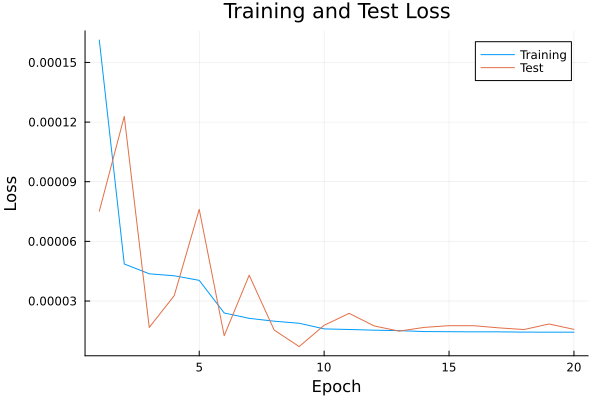

In [15]:

using Plots

function plot_loss(train_loss::Vector, test_loss::Vector; xlabel="Epoch", ylabel="Loss", title="Training and Test Loss")
    plot(train_loss ./ (size(training_data[3,:] / batchsize)), label="Training", xlabel=xlabel, ylabel=ylabel, title=title)
    plot!(test_loss ./ (size(test_data[3,:] / batchsize)), label="Test")
end

plot_loss(training_losses, test_losses)